# Imports

In [50]:
#!pip install obonet  numpy pandas matplotlib  sklearn python-bidi arabic_reshaper 
#!wget http://purl.obolibrary.org/obo/go.obo

import requests,math,pickle
import networkx,obonet
import time
import numpy as np ,pandas as pd, matplotlib.pyplot as plt
import arabic_reshaper
import multiprocessing as mp
from sklearn.metrics.cluster import *
from bidi.algorithm import get_display
from functools import partial
from IPython.display import clear_output
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

def fa(text):
    return get_display(arabic_reshaper.reshape(u'%s' % str(text)))

In [51]:
dataset_name = "CAMI_Low"
num_cores = max(mp.cpu_count() - 3, 1)
!mkdir -p ./Output/{dataset_name}/figs
!mkdir -p ./Temp/{dataset_name}/

In [52]:
def to_biobox(df, path):
    df[df["bin_id"]!= 0].to_csv(path, index=None, sep='\t',header=None)    
    with open(path, 'r') as file:        
        text = file.read()
    with open(path, 'w', encoding='utf8') as file:
        file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

# Read Fasta

In [53]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    ids = []
    contigs = []
    for l in lines:
        if(l[0]=='>'):
            ids.append(l)        
            contigs.append(s)
            s = ''
        else:
            s += l    
    contigs.append(s)
    df = pd.DataFrame(
            {
                '#anonymous_gsa_id': ids,
                'contig': contigs[1:]
            })
    df['#anonymous_gsa_id'] = df['#anonymous_gsa_id'].apply(lambda x: x[1:])    
    return df

In [54]:
contigs = fasta_to_df(f"./Dataset/{dataset_name}/contigs.fna")
all_number = contigs.shape[0]
contigs.head(2)

,#anonymous_gsa_id,contig
0,RL|S1|C0,TCTCCGCCGACGAGAGCTACACGTTCGACCGTGATCACGCCGACTG...
1,RL|S1|C1,CCTGGCCATACTTTTCCTTTCATATAAGGTCCATCAGCACGTTTAC...


In [55]:
df = pd.read_csv(f"./Dataset/{dataset_name}/mapping.tsv", sep='\t')
contigs = pd.merge(contigs, df, how='inner', on='#anonymous_gsa_id')
contigs["contig_length"] = contigs["contig"].apply(lambda x: len(x))
contigs.head(2)

,#anonymous_gsa_id,contig,bin_id,tax_id,sequence_id,number_reads,contig_length
0,RL|S1|C0,TCTCCGCCGACGAGAGCTACACGTTCGACCGTGATCACGCCGACTG...,1220_AJ,75309,scaffold5.1_1_from_14912_to_15720_total_809,12,809
1,RL|S1|C1,CCTGGCCATACTTTTCCTTTCATATAAGGTCCATCAGCACGTTTAC...,1048993,328515,scaffold00001_11_from_606387_to_607012_total_626,16,626


# Save gold standard data as CAMI binning Bioboxes format.

In [56]:
path = f"./Temp/{dataset_name}/gold_standard"
contigs[['#anonymous_gsa_id', 'bin_id', 'tax_id',
         'contig_length']].to_csv(path, index=None, sep='\t')

with open(path, 'r') as file:
    file.readline()
    text = file.read()

with open(path, 'w', encoding='utf8') as file:
    file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\tTAXID\t_LENGTH\n"+ text)

# Base Algorithms

In [57]:
metabat1_p30 = pd.read_csv(f"./Binning/{dataset_name}/Metabat1/prob30/contigs.tab", sep='\t', header = None)
metabat1_p30.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(metabat1_p30, f"./Temp/{dataset_name}/metabat1_p30")
print(metabat1_p30.shape[0])
print(f'{round(metabat1_p30[metabat1_p30["bin_id"]!= 0].shape[0]*100 / all_number,2)}% assigned')
metabat1_p30.head(2)

5986
30.7% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C19179,1
1,RL|S1|C19147,1


In [58]:
metabat1_p50 = pd.read_csv(f"./Binning/{dataset_name}/Metabat1/prob50/contigs.tab", sep='\t', header = None)
metabat1_p50.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(metabat1_p50, f"./Temp/{dataset_name}/metabat1_p50")
print(metabat1_p50.shape)
print(f'{round(metabat1_p50[metabat1_p50["bin_id"]!= 0].shape[0]*100 / all_number,2)}% assigned')
metabat1_p50.head(2)

(5710, 2)
29.28% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C19179,1
1,RL|S1|C19147,1


In [59]:
metabat1_p70 = pd.read_csv(f"./Binning/{dataset_name}/Metabat1/prob70/contigs.tab", sep='\t', header = None)
metabat1_p70.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(metabat1_p70, f"./Temp/{dataset_name}/metabat1_p70")
print(metabat1_p70.shape)
print(f'{round(metabat1_p70[metabat1_p70["bin_id"]!= 0].shape[0]*100 / all_number,2)}% assigned')
metabat1_p70.head(2)

(5815, 2)
29.82% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C19179,1
1,RL|S1|C19147,1


In [60]:
metabat1_p80 = pd.read_csv(f"./Binning/{dataset_name}/Metabat1/prob80/contigs.tab", sep='\t', header = None)
metabat1_p80.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(metabat1_p80, f"./Temp/{dataset_name}/metabat1_p80")
print(metabat1_p80.shape)
print(f'{round(metabat1_p80[metabat1_p80["bin_id"]!= 0].shape[0]*100 / all_number,2)}% assigned')
metabat1_p80.head(2)

(5673, 2)
29.09% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C19147,1
1,RL|S1|C19085,1


In [61]:
metabat1_p90 = pd.read_csv(f"./Binning/{dataset_name}/Metabat1/prob90/contigs.tab", sep='\t', header = None)
metabat1_p90.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(metabat1_p90, f"./Temp/{dataset_name}/metabat1_p90")
print(metabat1_p90.shape)
print(f'{round(metabat1_p90[metabat1_p90["bin_id"]!= 0].shape[0]*100 / all_number,2)}% assigned')
metabat1_p90.head(2)

(5322, 2)
27.29% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C19446,1
1,RL|S1|C19333,1


In [62]:
metabat1_p95 = pd.read_csv(f"./Binning/{dataset_name}/Metabat1/prob95/contigs.tab", sep='\t', header = None)
metabat1_p95.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(metabat1_p95, f"./Temp/{dataset_name}/metabat1_p95")
print(metabat1_p95.shape)
print(f'{round(metabat1_p95[metabat1_p95["bin_id"]!= 0].shape[0]*100 / all_number,2)}% assigned')
metabat1_p95.head(2)

(5021, 2)
25.75% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C19446,1
1,RL|S1|C19333,1


In [63]:
metabat2_p50 = pd.read_csv(f"./Binning/{dataset_name}/Metabat2/prob50/contigs.tab", sep='\t', header = None)
metabat2_p50.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(metabat2_p50, f"./Temp/{dataset_name}/metabat2_p50")
print(metabat2_p50.shape)
print(f'{round(metabat2_p50[metabat2_p50["bin_id"]!= 0].shape[0]*100 / all_number,2)}% assigned')
metabat2_p50.head(2)

(3869, 2)
19.84% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C9238,1
1,RL|S1|C15230,1


In [64]:
metabat2_p95 = pd.read_csv(f"./Binning/{dataset_name}/Metabat2/prob95/contigs.tab", sep='\t', header = None)
metabat2_p95.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(metabat2_p95, f"./Temp/{dataset_name}/metabat2_p95")
print(metabat2_p95.shape)
print(f'{round(metabat2_p95[metabat2_p95["bin_id"]!= 0].shape[0]*100 / all_number,2)}% assigned')
metabat2_p95.head(2)

(1687, 2)
8.65% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C6180,1
1,RL|S1|C7437,1


In [65]:
maxbin2_p50 = pd.read_csv(f"./Binning/{dataset_name}/Maxbin2/prob50/contigs.tab", sep='\t', header = None)
maxbin2_p50.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(maxbin2_p50, f"./Temp/{dataset_name}/maxbin2_p50")
print(maxbin2_p50.shape)
print(f'{round(maxbin2_p50[maxbin2_p50["bin_id"]!= 0].shape[0]*100 / all_number,2)}% assigned')
maxbin2_p50.head(2)

FileNotFoundError: [Errno 2] No such file or directory: './Binning/CAMI_Low/Maxbin2/prob50/contigs.tab'

In [66]:
maxbin2_p80 = pd.read_csv(f"./Binning/{dataset_name}/Maxbin2/prob80/contigs.tab", sep='\t', header = None)
maxbin2_p80.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(maxbin2_p80, f"./Temp/{dataset_name}/maxbin2_p80")
print(maxbin2_p80.shape)
print(f'{round(maxbin2_p80[maxbin2_p80["bin_id"]!= 0].shape[0]*100 / all_number,2)}% assigned')
maxbin2_p80.head(2)

(7567, 2)
38.81% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C135,7
1,RL|S1|C465,7


In [67]:
maxbin2_p90 = pd.read_csv(f"./Binning/{dataset_name}/Maxbin2/prob90/contigs.tab", sep='\t', header = None)
maxbin2_p90.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(maxbin2_p90, f"./Temp/{dataset_name}/maxbin2_p90")
print(maxbin2_p90.shape)
print(f'{round(maxbin2_p90[maxbin2_p90["bin_id"]!= 0].shape[0]*100 / all_number,2)}% assigned')
maxbin2_p90.head(2)

(7498, 2)
38.45% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C135,7
1,RL|S1|C465,7


In [23]:
maxbin2_p95 = pd.read_csv(f"./Binning/{dataset_name}/Maxbin2/prob95/contigs.tab", sep='\t', header = None)
maxbin2_p95.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(maxbin2_p95, f"./Temp/{dataset_name}/maxbin2_p95")
print(maxbin2_p95.shape)
print(f'{round(maxbin2_p95[maxbin2_p95["bin_id"]!= 0].shape[0]*100 / all_number,2)}% assigned')
maxbin2_p95.head(2)

(7227, 2)
37.06% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C465,7
1,RL|S1|C618,7


# Gene Ontology
## https://www.ebi.ac.uk/QuickGO/api/index.html#/gene_ontology

In [29]:
go = pd.read_csv(f"./Annotation/{dataset_name}/cds.gene2go.tab.txt", sep='\t')
go = go.reset_index(drop=True)
go.head(2)

,#Gene,Contig,Start,End,Gene_Length,Strand,SP,TM,go_id,Taxonomy
0,RL|S1|C13963,1160,2104,945,1,No,0,GO:0016811,"hydrolase activity, acting on carbon-nitrogen ...",d__Bacteria;p__Actinobacteriota;c__Actinobacte...
1,RL|S1|C13963,1160,2104,945,1,No,0,GO:0019740,nitrogen utilization,d__Bacteria;p__Actinobacteriota;c__Actinobacte...


## Add namespace [ cc, bp, mf ]

In [30]:
go_graph = obonet.read_obo('./go.obo') 
accession_to_namespace = dict()
go_ids = go['TM'].unique()
for accession in go_ids:
    try:        
        accession_to_namespace[accession] =  go_graph.nodes[accession]['namespace']
    except: 
        # if not exist,store in list to get from API                        
        r = requests.get("https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/" + accession
                     , headers={ "Accept" : "application/json"})
        if not r.ok:
            print(f'Not found ', r.raise_for_status())                                              
        else:
            accession_to_namespace[accession]= r.json()['results'][0]['aspect']         

In [31]:
def get_namespace(accession):
    if(accession in accession_to_namespace):        
        return accession_to_namespace[accession]    
    return "unknown"

go['Namespace'] = go['TM'].apply(lambda x : get_namespace(x) )
print(go['Namespace'].value_counts())
go.head(2)

molecular_function    196928
biological_process    138153
cellular_component     79222
Name: Namespace, dtype: int64


,#Gene,Contig,Start,End,Gene_Length,Strand,SP,TM,go_id,Taxonomy,Namespace
0,RL|S1|C13963,1160,2104,945,1,No,0,GO:0016811,"hydrolase activity, acting on carbon-nitrogen ...",d__Bacteria;p__Actinobacteriota;c__Actinobacte...,molecular_function
1,RL|S1|C13963,1160,2104,945,1,No,0,GO:0019740,nitrogen utilization,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,biological_process


# Improver Method

## Create dictionary BP, CC , MF base of GOGO for each pair of go ids

In [78]:
def runGOGO(i,namespace):        
    %cd ./GOGO/
    !perl go_comb.pl ../Temp/{dataset_name}/{namespace}/go_ids{i}.txt ../Temp/{dataset_name}/{namespace}/go_ids_scores{i}
    %cd ..    

In [79]:
def Step1(namespace):    
    !rm -r ./Temp/{dataset_name}/{namespace}/ 
    !mkdir ./Temp/{dataset_name}/{namespace}/
    # first create all possible pairs of GOs for Biological Process
    go_ids = go[go["Namespace"] == namespace]['TM'].unique()    
    go1 = []
    go2 = []
    for i in range(0,go_ids.shape[0]):
        for j in range(i, go_ids.shape[0]):            
            go1.append(go_ids[i])
            go2.append(go_ids[j])
    df = pd.DataFrame({'goid1': go1,'goid2': go2},columns = ['goid1', 'goid2'])
    indexes = np.linspace(0,df.shape[0], num_cores + 1) // 1
    indexes[-1] =  df.shape[0]
    
    for i in range(0, num_cores):
        dfi = df.iloc[int(indexes[i]):int(indexes[i+1]),:]
        dfi.to_csv(f"./Temp/{dataset_name}/{namespace}/go_ids{i}.txt",sep=" ",index=None,header=None)
        
    # now run GOGO in multiprocessing
    if __name__ == '__main__':        
        pool = mp.Pool(num_cores)        
        pool.map(partial(runGOGO, namespace=namespace), range(0,num_cores))      
        
    clear_output()

In [85]:
def Step2(namespace):            
    def add2dict(row, dictionary):
        dictionary[row[0]+row[1]] = row[3]
        dictionary[row[1]+row[0]] = row[3]
    print('start reading files')            
    lines = []
    for i in range(0,num_cores):
        with open(f"./Temp/{dataset_name}/{namespace}/go_ids_scores{i}","r") as f:
            text = f.read()
            lines = [*lines, *[l for l in text.split("\n") if len(l) > 0 and l[-24:] != "not_in_the_same_ontology"]]                        
    print('files reading process was finished.')        
    print('start adding to dictionary')        
    df = pd.read_csv(StringIO('\n'.join(lines)), sep=" ", header=None)                
    dictionary = dict()    
    df.apply(lambda row:add2dict(row, dictionary), axis=1)
    print('adding to dictionary was finished')                   
    with open(f"./Temp/{dataset_name}/{namespace}.pkl", "wb") as file:
        pickle.dump(dictionary, file)        
    !rm -r ./Temp/{dataset_name}/{namespace}/    

### biological process

In [81]:
Step1("biological_process")

In [82]:
Step2("biological_process")

### cellular component

In [83]:
Step1("cellular_component")

In [84]:
Step2("cellular_component")

### molecular function

In [86]:
Step1("molecular_function")

In [87]:
Step2("molecular_function")

start reading files
files reading process was finished.
start adding to dictionary
adding to dictionary was finished


## Load data

In [32]:
base = maxbin2_p95
unlabelled = contigs[~contigs['#anonymous_gsa_id'].isin(base['#anonymous_gsa_id'])]

In [33]:
number_of_bins = base['bin_id'].max() 

bins = [0 for i in range(0,number_of_bins)]
for i in range(0, number_of_bins):    
    bins[i] = pd.merge(go, base[base['bin_id']==(i+1)], how="inner", 
                    left_on='#Gene',right_on="#anonymous_gsa_id")

In [34]:
with open(f"./Temp/{dataset_name}/biological_process.pkl", "rb") as file:
    bp_dictionary = pickle.load(file)

with open(f"./Temp/{dataset_name}/cellular_component.pkl", "rb") as file:
    cc_dictionary = pickle.load(file)
    
with open(f"./Temp/{dataset_name}/molecular_function.pkl", "rb") as file:
    mf_dictionary = pickle.load(file)

In [35]:
go_rare = go.groupby("TM")["TM"].count()
upper_value = np.percentile(go_rare.values, 75)
print(f'upper_value : {upper_value}')
go_rare = go_rare.apply(lambda x : min(x,upper_value))
go_rare = go_rare.apply(lambda x : ((upper_value - x) + 1)/upper_value)

upper_value : 29.0


In [36]:
'''source = []
target = []
weigth = []
TM = df['TM'].to_numpy()
Go_id = df['go_id'].to_numpy()

for i in range(0, len(TM)-1):
    for j in range(i+1, len(TM)):                
        if(TM[i] + TM[j] in bp_dictionary):
                if(bp_dictionary[TM[i] + TM[j]] > 0.7):
                    source.append(Go_id[i])
                    target.append(Go_id[j])
                    weigth.append(bp_dictionary[ TM[i] + TM[j]])            
df = pd.DataFrame({'source': source, 'target': target, 'weigth': weigth})
df.to_csv('./data.csv', index=None)''';

## Disjoint

### 16S

In [127]:
'''
with open("Annotation/Toy_Low/data/16SrRNA.ffn", "r") as file:    
    lines = [t for t in file.read().split('\n') if len(t) > 0]
    lines = [t for t in lines if t[0] == '>']
    rRNA16S = pd.read_csv(StringIO('\n'.join(lines)), sep="/", header=None)                
    rRNA16S = rRNA16S.iloc[:,1:]
    rRNA16S.columns = ["Name", "rRNA_taxon", "cid"]
    rRNA16S["Name"] = rRNA16S["Name"].apply(lambda x : x.replace("Name=",""))
    rRNA16S["rRNA_taxon"] = rRNA16S["rRNA_taxon"].apply(lambda x : x.replace("rRNA_taxon=",""))
    rRNA16S["cid"] = rRNA16S["cid"].apply(lambda x : x.replace("cid=",""))
print(rRNA16S.shape)
rRNA16S.head()

bins = [[] for i in range(0,number_of_bins+1)]
for i in range(1, number_of_bins+1):
    df = contigs[contigs['Busybee_bin50Percent']==i]
    df = pd.merge(df, rRNA16S, how="inner", left_on="#anonymous_gsa_id", right_on="cid")    
    for index, row in df.iterrows():
        bins[i].append(row['rRNA_taxon'])    
    bins[i] = [s for s in set(bins[i])]    
    
[i for i in range(1, number_of_bins+1) if len(bins[i]) > 1]''';

## Main loop

In [47]:
number = 5
power_coeff = 1

def getDictionary(namespace):
    if(namespace == "biological_process"):
        return bp_dictionary
    if(namespace == "cellular_component"):
        return cc_dictionary    
    if(namespace == "molecular_function"):
        return mf_dictionary
    
# this function recived a contig and return pred bin and score
def binScore(inp_bin, go_id,dictionary):        
    def run(g1,g2):
        pair = g1 + g2
        if(pair in dictionary):          
            return go_rare[g1] * go_rare[g2] * dictionary[pair] ** power_coeff
        return -1    
    scores = pd.Series(inp_bin['TM'].unique()).apply(lambda g: run(g , go_id))    
    scores = scores[scores >= 0]    
    if(scores.shape[0] == 0):
        return 0
    st = sorted(scores,reverse=True)[:number]
    return sum(st) / len(st)

def getScore(go_id):            
    result = np.zeros(number_of_bins)    
    namespace = accession_to_namespace[go_id]
    for i in range(0,number_of_bins):
        result[i] = binScore(bins[i], go_id, getDictionary(namespace))
    return go_id, result

if __name__ == '__main__':
    pool = mp.Pool(num_cores)    
    go_ids = pd.merge(unlabelled, go, how='inner',
             left_on='#anonymous_gsa_id',right_on='#Gene')['TM'].unique()

    go_dictionary = dict()
    for go_id, result in pool.map(getScore, go_ids):        
        go_dictionary[go_id] = result

## Pred

In [48]:
alpha = 1  # BP
beta  = 0.1  # CC
gamma = 1  # MF

def getCoefficient(namespace):
        if(namespace == "biological_process"):
            return alpha
        if(namespace == "cellular_component"):
            return beta    
        if(namespace == "molecular_function"):
            return gamma    
    
def pred(cnt):                                
    coeff = 0
    selected = go[go['#Gene'] == cnt]
    go_ids = selected['TM']                
    go_namespace = selected['Namespace']                
    result = np.zeros((go_ids.shape[0], number_of_bins))    
    for i in range(0,len(go_ids.index)):  
        index = go_ids.index[i]               
        namespace = go_namespace[index]        
        coeff += getCoefficient(namespace)                                         
        result[i,:] = go_dictionary[go_ids[index]] * getCoefficient(namespace)                 
    score = sum(result) / coeff if coeff != 0 else sum(result) * 0    
    index = np.where(score == max(score))[0][0] + 1                
    return index, max(score), cnt    

if __name__ == '__main__':
    answer = {}        
    pool = mp.Pool(num_cores)    
    unlabelledContigs = pd.Series(list(set(unlabelled['#anonymous_gsa_id']).intersection(set(go['#Gene']))))        
    for index, score, cnt in pool.map(pred,unlabelledContigs):        
        answer[cnt] = (index,  score)

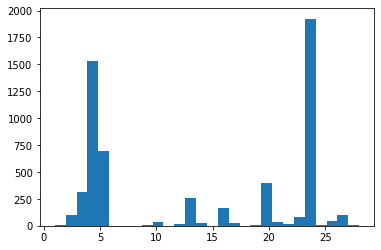

In [49]:
plt.hist([v[0] for v in answer.values()],bins=base['bin_id'].max());

In [40]:
threshold = 0.05
counter = 0
def assign(row):
    global counter
    cnt = row['#anonymous_gsa_id']
    if(cnt in answer and answer[cnt][1] >= threshold):                
        counter += 1
        return answer[cnt][0]    
    return 0

unlabelled['pred'] = unlabelled.apply(lambda row:assign(row),axis=1)    
print(counter)

415


<ipython-input-40-13fa229bafae>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabelled['pred'] = unlabelled.apply(lambda row:assign(row),axis=1)


In [41]:
df = unlabelled[unlabelled['pred']!=0][['#anonymous_gsa_id','pred']]
df.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(pd.concat([base,df]), f"./Temp/{dataset_name}/improved")

In [42]:
!amber.py -g ./Temp/{dataset_name}/gold_standard \
-o ./Output/{dataset_name}/Assesment \
./Temp/{dataset_name}/metabat2_p50 \
./Temp/{dataset_name}/metabat2_p95 \
./Temp/{dataset_name}/maxbin2_p50 \
./Temp/{dataset_name}/maxbin2_p80 \
./Temp/{dataset_name}/maxbin2_p95 \
./Temp/{dataset_name}/improved                  

2021-07-18 21:58:09,708 INFO Loading Gold standard
2021-07-18 21:58:09,760 INFO Loading metabat2_p50
2021-07-18 21:58:09,777 INFO Loading metabat2_p95
2021-07-18 21:58:09,789 INFO Loading maxbin2_p50
2021-07-18 21:58:09,817 INFO Loading maxbin2_p80
2021-07-18 21:58:09,843 INFO Loading maxbin2_p95
2021-07-18 21:58:09,867 INFO Loading improved
2021-07-18 21:58:09,893 INFO Creating output directories
2021-07-18 21:58:09,895 INFO Evaluating Gold standard (sample gsa, genome binning)
2021-07-18 21:58:10,095 INFO Evaluating metabat2_p50 (sample gsa, genome binning)
2021-07-18 21:58:10,273 INFO Evaluating metabat2_p95 (sample gsa, genome binning)
2021-07-18 21:58:10,464 INFO Evaluating maxbin2_p50 (sample gsa, genome binning)
2021-07-18 21:58:10,646 INFO Evaluating maxbin2_p80 (sample gsa, genome binning)
2021-07-18 21:58:10,825 INFO Evaluating maxbin2_p95 (sample gsa, genome binning)
2021-07-18 21:58:11,001 INFO Evaluating improved (sample gsa, genome binning)
2021-07-18 21:58:11,182 INFO Sa

# KEGG

In [ ]:
kegg = pd.read_csv('./Annotation/Toy_low/data/cds.gene2kegg.tab.txt',sep='\t')
print(kegg.shape)
kegg = pd.merge(kegg,Geneid2Contigid,how='inner',on='#Geneid')
kegg.head(2)

In [ ]:
print(np.median(list(kegg['Kegg_id'].value_counts())))
plt.plot(list(kegg['Kegg_id'].value_counts()))
plt.show()

# KO

In [ ]:
ko = pd.read_csv('./Annotation/Toy_low/data/cds.gene2ko.tab.txt',sep='\t')
print(ko.shape)
ko.head(5)

In [ ]:
print(np.median(list(ko['koid'].value_counts())))
plt.plot(list(ko['koid'].value_counts()))
plt.show()

In [ ]:
print(np.median(list(ko['Contig'].value_counts())))
plt.plot(list(ko['Contig'].value_counts()))
plt.show()

In [ ]:
df = pd.read_csv('./Annotation/Toy_low/data/cds.gene2sprot.tab.txt',sep='\t')
print(df.shape)
df.head(2)

In [ ]:
uniprot = pd.read_csv('./uniprot-filtered-reviewed-yes.tab',sep='\t')
print(uniprot.shape)
uniprot.head(2)

In [ ]:
df = pd.merge(uniprot,df,how='inner',left_on='Protein names',right_on='sprot_desc')
print(df.shape)
df.head(2)